In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
nltk.download("stopwords")

# Load dataset
df = pd.read_csv(r"C:\Users\fake_job_postings.csv")
print("Data shape:", df.shape)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [2]:
# Fill missing values
text_cols = ['title', 'location', 'company_profile', 'description', 'requirements', 'benefits', 'industry']
cat_cols = ['department', 'salary_range', 'employment_type', 'required_experience', 'required_education', 'function']
num_cols = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

for col in text_cols + cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,Unknown,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unknown,0,1,0,Other,Internship,Unknown,Unknown,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Unknown,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Unknown,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unknown,Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unknown,0,1,0,Unknown,Unknown,Unknown,Unknown,Unknown,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Unknown,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",Unknown,Unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
# Combine text fields into a single column
df['text'] = df[['title', 'location', 'company_profile', 'description', 'requirements', 'benefits', 'industry']].astype(str).agg(" ".join, axis=1)
df = df[['text', 'fraudulent']]  # Keep only necessary columns
df.head()


,text,fraudulent
0,"Marketing Intern US, NY, New York We're Food52...",0
1,"Customer Service - Cloud Video Production NZ, ...",0
2,"Commissioning Machinery Assistant (CMA) US, IA...",0
3,"Account Executive - Washington DC US, DC, Wash...",0
4,"Bill Review Manager US, FL, Fort Worth SpotSou...",0


In [4]:
# Vectorize the combined text column
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['fraudulent']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Show balanced class distribution
print("Balanced class distribution:\n", pd.Series(y_smote).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)


Balanced class distribution:
 fraudulent
0    17014
1    17014
Name: count, dtype: int64


Naive Bayes Accuracy: 0.9484278577725537
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3396
           1       0.94      0.96      0.95      3410

    accuracy                           0.95      6806
   macro avg       0.95      0.95      0.95      6806
weighted avg       0.95      0.95      0.95      6806



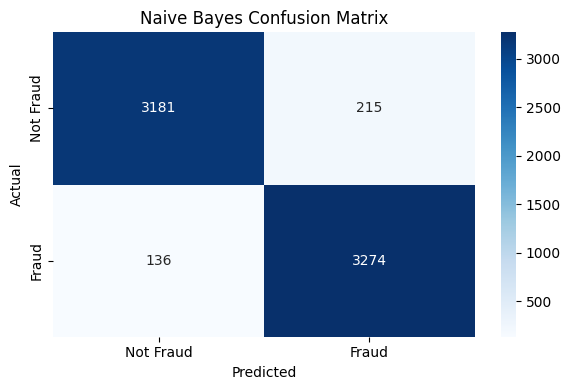

<Figure size 600x400 with 0 Axes>

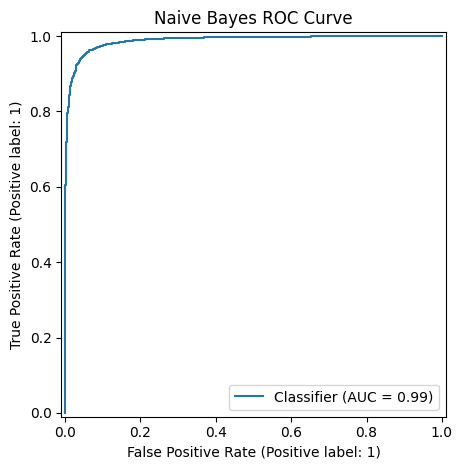

In [5]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

# Print metrics
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_test, y_proba_nb)
plt.title("Naive Bayes ROC Curve")
plt.tight_layout()
plt.show()



Random Forest Accuracy: 0.998383779018513
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3396
           1       1.00      1.00      1.00      3410

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



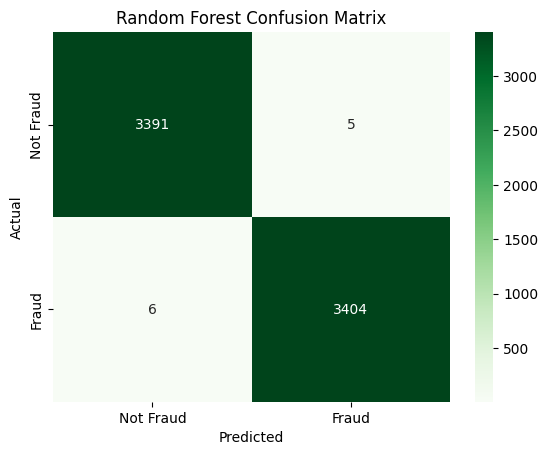

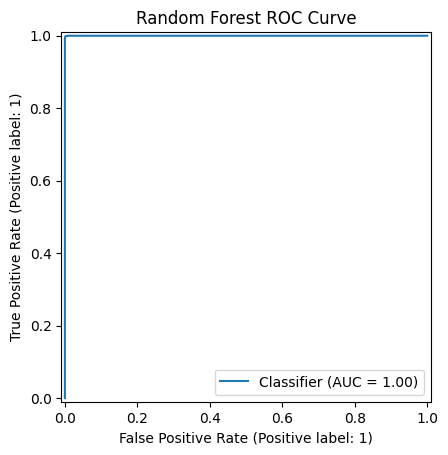

In [6]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest ROC Curve")
plt.show()


XGBoost Accuracy: 0.994122832794593
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3396
           1       1.00      0.99      0.99      3410

    accuracy                           0.99      6806
   macro avg       0.99      0.99      0.99      6806
weighted avg       0.99      0.99      0.99      6806



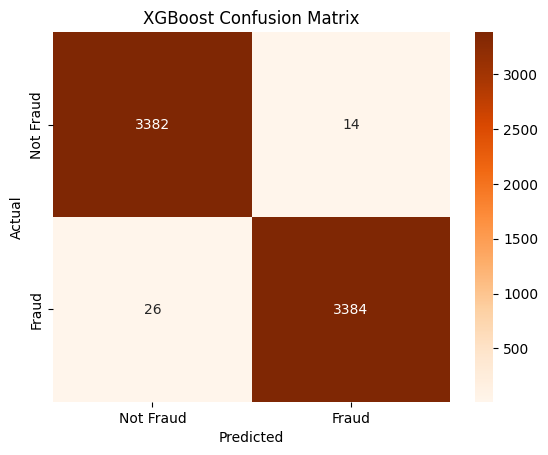

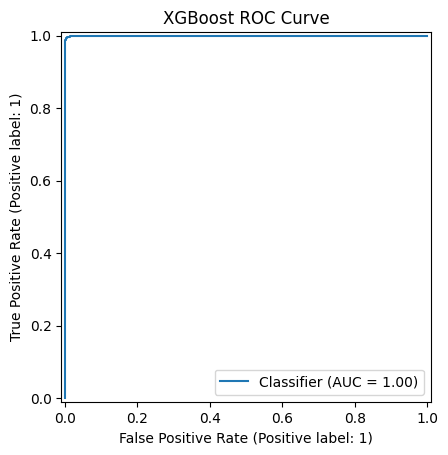

In [7]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("XGBoost ROC Curve")
plt.show()


SVM Accuracy: 0.9935351160740523
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3396
           1       0.99      1.00      0.99      3410

    accuracy                           0.99      6806
   macro avg       0.99      0.99      0.99      6806
weighted avg       0.99      0.99      0.99      6806



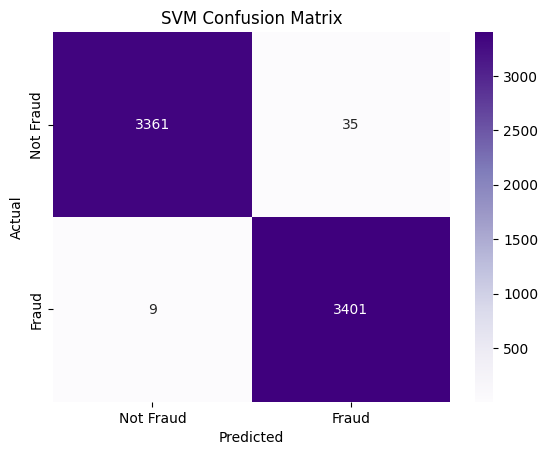

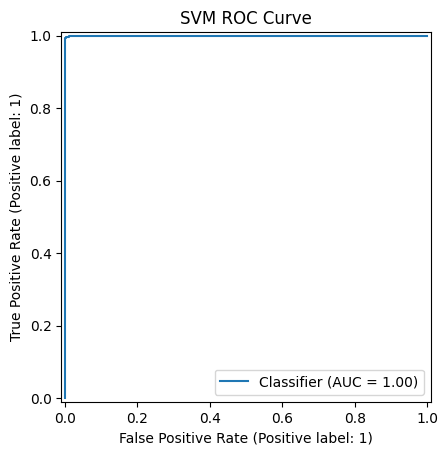

In [8]:
# SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_svm)
plt.title("SVM ROC Curve")
plt.show()
